In [162]:
#%pip install pandas
#%pip install matplotlib
#%pip install networkx
#%pip install ortools
#%pip install seaborn
#%pip install statsmodels
#%pip install scikit-learn
%pip install ace_tools

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#Import
import pandas as pd
import os

import numpy as np #muss nachher weg!
import random #muss nachher weg!

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

#linear regression
import seaborn as sns

import matplotlib.pyplot as plt
import networkx as nx

ModuleNotFoundError: No module named 'ace_tools'

In [142]:
# CSV-Dateien laden
output_df = pd.read_csv('output.csv')
data = pd.read_csv('C:/Users\zombulli/OneDrive - Carl Zeiss AG/Desktop/DHBW/latest_container.csv')

# Spaltennamen bereinigen
output_df.columns = output_df.columns.str.strip()
data.columns = data.columns.str.strip()

# Koordinaten hinzufügen und Adressen aktualisieren
merged_df = data.merge(output_df[['old_adresses', 'Coordinate']], left_on='Adresse', right_on='old_adresses', how='left')

# Adressen überschreiben
merged_df['Adresse'] = merged_df['old_adresses']
merged_df.drop(columns=['old_adresses'], inplace=True)

# Ergebnis anzeigen (nur die ersten 5 Zeilen)
print(merged_df.head(5))

<>:3: SyntaxWarning: invalid escape sequence '\z'
<>:3: SyntaxWarning: invalid escape sequence '\z'
C:\Users\zombulli\AppData\Local\Temp\ipykernel_33748\2394099071.py:3: SyntaxWarning: invalid escape sequence '\z'
  data = pd.read_csv('C:/Users\zombulli/OneDrive - Carl Zeiss AG/Desktop/DHBW/latest_container.csv')


  Container-ID        Stadtteil                       Adresse       Datum  \
0    KA-0000-W  Aue/Lohn-Lissen  Auer Straße/Hildebrandstraße  2024-01-01   
1    KA-0000-W  Aue/Lohn-Lissen  Auer Straße/Hildebrandstraße  2024-01-01   
2    KA-0000-W  Aue/Lohn-Lissen  Auer Straße/Hildebrandstraße  2024-01-01   
3    KA-0000-W  Aue/Lohn-Lissen  Auer Straße/Hildebrandstraße  2024-01-01   
4    KA-0000-W  Aue/Lohn-Lissen  Auer Straße/Hildebrandstraße  2024-01-02   

  Uhrzeit  Füllstand (%)  Containergröße (m³) Container-Typ  \
0   06:00            1.9                  2.5          Weiß   
1   08:00            3.8                  2.5          Weiß   
2   14:00            5.7                  2.5          Weiß   
3   18:00            7.6                  2.5          Weiß   
4   06:00            2.1                  2.5          Weiß   

             Coordinate  
0  49.0082292,8.4032381  
1  49.0082292,8.4032381  
2  49.0082292,8.4032381  
3  49.0082292,8.4032381  
4  49.0082292,8.4032381  


In [143]:
df = merged_df

df['Datetime'] = pd.to_datetime(df['Datum'] + ' ' + df['Uhrzeit'])

df_sorted = df.sort_values(by=['Container-ID', 'Datetime'], ascending=[True, False])

df_latest = df_sorted.drop_duplicates(subset='Container-ID', keep='first')

df_latest = df_latest.drop(columns='Datetime')

df_latest.reset_index(drop=True, inplace=True)

merged_df.dropna(subset=['Coordinate'], inplace=True)

df_latest.to_csv('df_latest.csv', index=False)

print(df_latest.tail(5))

    Container-ID                          Stadtteil Adresse       Datum  \
716    KA-0716-B                     Wolfarts­weier     NaN  2024-12-31   
717    KA-0717-W  Schloß­berg­straße (beim Freibad)     NaN  2024-12-31   
718    KA-0718-G  Schloß­berg­straße (beim Freibad)     NaN  2024-12-31   
719    KA-0719-W  Schloß­berg­straße (beim Freibad)     NaN  2024-12-31   
720    KA-0720-G  Schloß­berg­straße (beim Freibad)     NaN  2024-12-31   

    Uhrzeit  Füllstand (%)  Containergröße (m³) Container-Typ Coordinate  
716   20:00           64.6                  2.5         Braun        NaN  
717   20:00          100.0                  2.5          Weiß        NaN  
718   16:00           62.9                  2.5          Grün        NaN  
719   18:00          100.0                  2.5          Weiß        NaN  
720   18:00          100.0                  2.5          Grün        NaN  


In [145]:
# Nur Zeilen mit gültigen Koordinaten behalten
output_df_clean = df_latest.dropna(subset=['Coordinate']).reset_index(drop=True)

# Container-IDs und Koordinaten synchron extrahieren
container_ids = output_df_clean['Container-ID'].values
coordinates = output_df_clean['Coordinate'].str.split(',', expand=True)
x = coordinates[0].astype(float).values
y = coordinates[1].astype(float).values

# Beispielkoordinaten anzeigen
print("Beispielkoordinaten:")
print(list(zip(container_ids[:10], x[:10], y[:10])))

Beispielkoordinaten:
[('KA-0000-W', np.float64(49.0082292), np.float64(8.4032381)), ('KA-0001-G', np.float64(49.0082292), np.float64(8.4032381)), ('KA-0002-B', np.float64(49.0082292), np.float64(8.4032381)), ('KA-0003-W', np.float64(49.0038792), np.float64(8.405614)), ('KA-0004-G', np.float64(49.0038792), np.float64(8.405614)), ('KA-0005-B', np.float64(49.0038792), np.float64(8.405614)), ('KA-0006-W', np.float64(49.0040852), np.float64(8.4006776)), ('KA-0007-G', np.float64(49.0040852), np.float64(8.4006776)), ('KA-0008-B', np.float64(49.0040852), np.float64(8.4006776)), ('KA-0009-W', np.float64(49.0070257), np.float64(8.4078911))]


In [146]:
edges = []
weights = []
distances = []

# Container-IDs und Koordinaten extrahieren
container_ids = output_df_clean['Container-ID'].values
coordinates = output_df_clean['Coordinate'].str.split(',', expand=True)
x = coordinates[0].astype(float).values
y = coordinates[1].astype(float).values

num_containers = len(container_ids)

# Kanten und Distanzen hinzufügen
for i in range(num_containers):
    # Zufälliger Ziel-Container (kein Selbstverweis)
    target = random.randint(0, num_containers - 1)
    while target == i:
        target = random.randint(0, num_containers - 1)

    # Kante hinzufügen
    edges.append((container_ids[i], container_ids[target]))
    weights.append(1)  # Alle Gewichte auf 1 setzen

    # Distanz berechnen
    dx = x[i] - x[target]
    dy = y[i] - y[target]
    distance = round(np.sqrt(dx**2 + dy**2), 5)  # Distanz mit 5 Dezimalstellen
    distances.append(distance)

# Daten zum DataFrame hinzufügen
output_df_clean['target_id'] = [target for source, target in edges]
output_df_clean['distance_to_target'] = distances
output_df_clean['weight'] = weights

# Ergebnis anzeigen (nur die ersten 10 Zeilen)
print(output_df_clean.head(5))

  Container-ID        Stadtteil                                  Adresse  \
0    KA-0000-W  Aue/Lohn-Lissen             Auer Straße/Hildebrandstraße   
1    KA-0001-G  Aue/Lohn-Lissen             Auer Straße/Hildebrandstraße   
2    KA-0002-B  Aue/Lohn-Lissen             Auer Straße/Hildebrandstraße   
3    KA-0003-W  Aue/Lohn-Lissen  Brühl­stra­ße/­Grenz­straße, Park­platz   
4    KA-0004-G  Aue/Lohn-Lissen  Brühl­stra­ße/­Grenz­straße, Park­platz   

        Datum Uhrzeit  Füllstand (%)  Containergröße (m³) Container-Typ  \
0  2024-12-31   18:00          100.0                  2.5          Weiß   
1  2024-12-31   20:00          100.0                  2.5          Grün   
2  2024-12-31   20:00           70.3                  2.5         Braun   
3  2024-12-31   18:00          100.0                  2.5          Weiß   
4  2024-12-31   20:00           35.4                  2.5          Grün   

             Coordinate  target_id  distance_to_target  weight  
0  49.0082292,8.4032381  KA

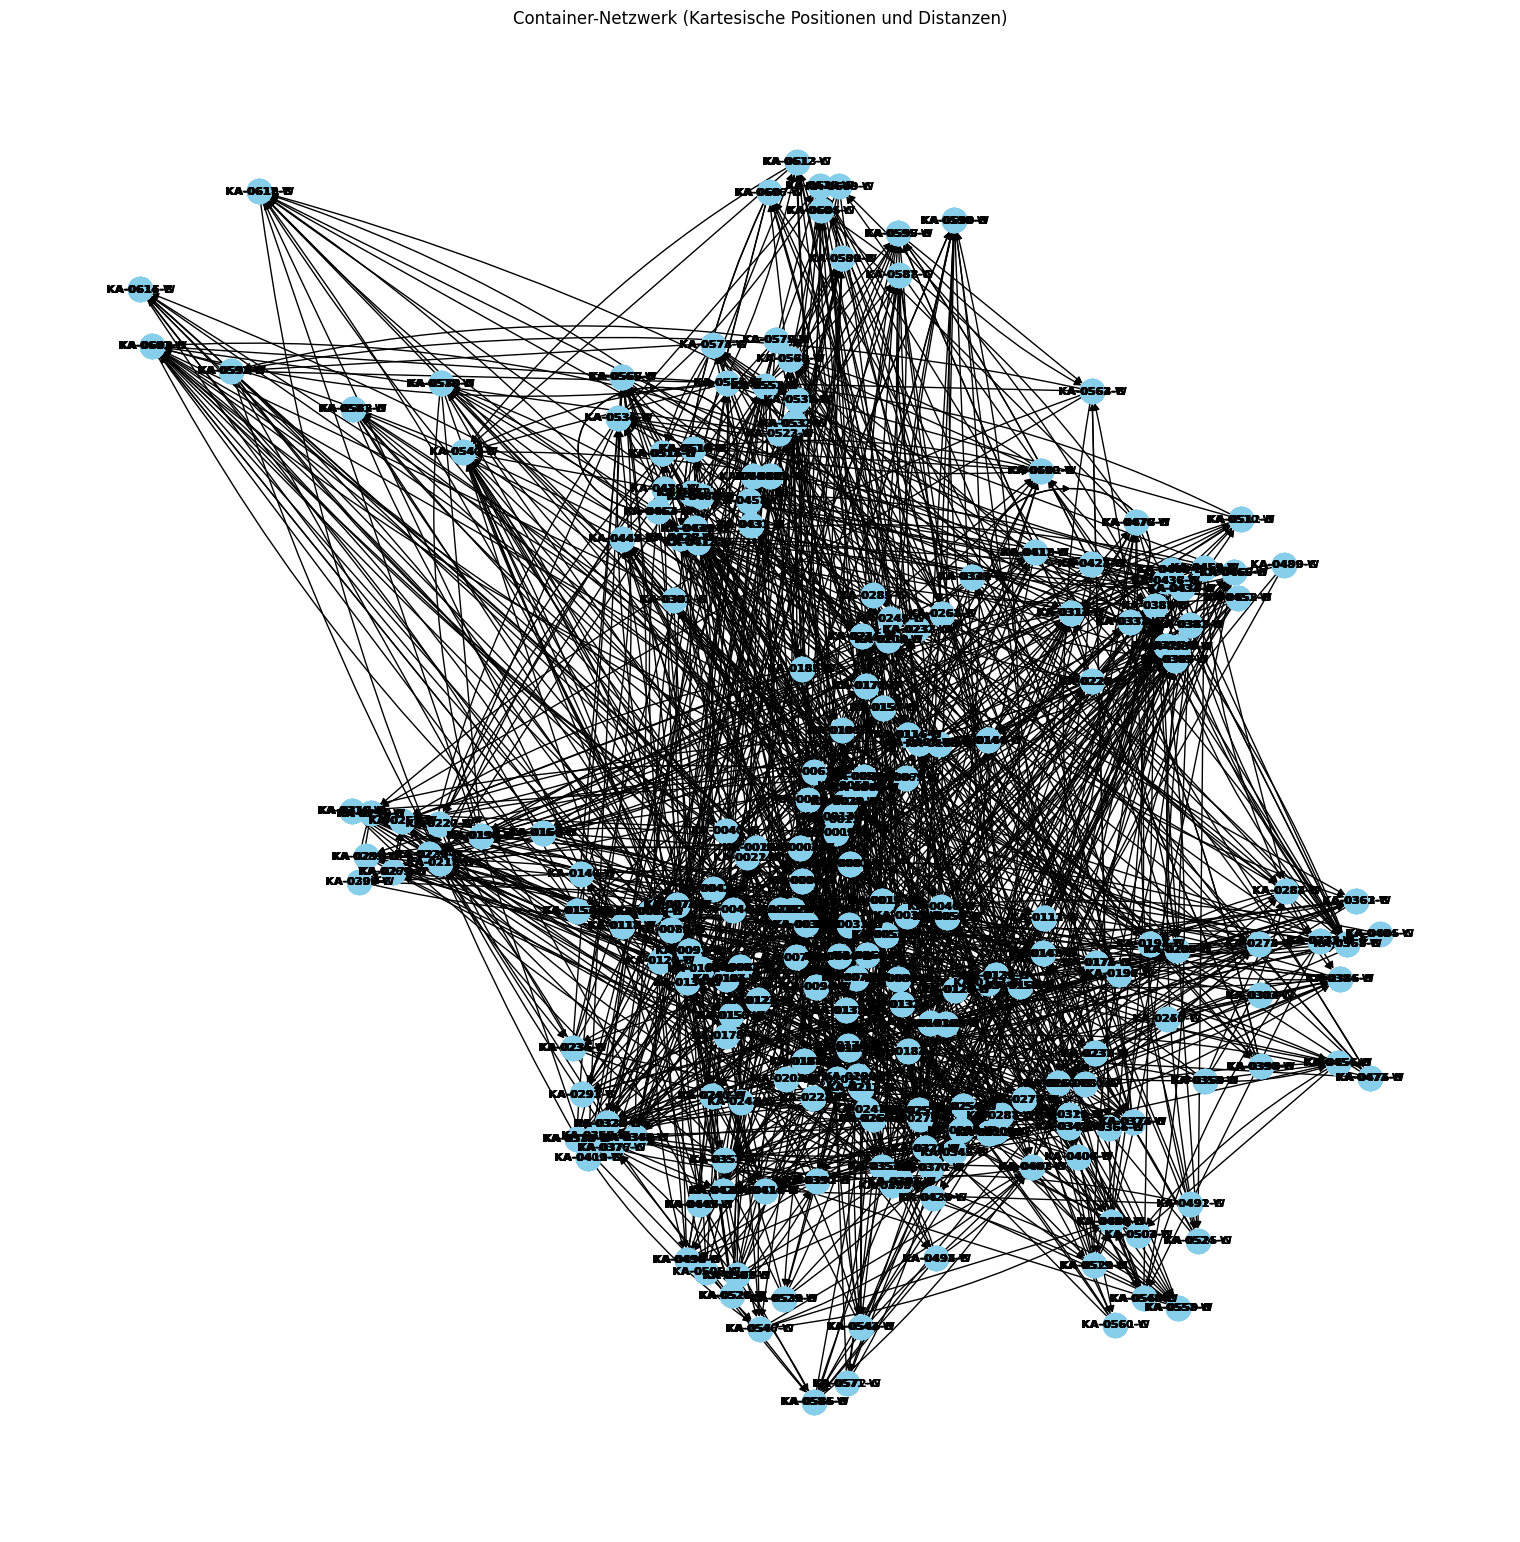

In [147]:
# Netzwerk erstellen
G = nx.DiGraph()
G.add_nodes_from(container_ids)
for i, (source, target) in enumerate(edges):
    G.add_edge(source, target, weight=weights[i], distance=distances[i])

# Netzwerk zeichnen
plt.figure(figsize=(15, 15))
pos = {container_ids[i]: (x[i], y[i]) for i in range(num_containers)}
# Set a simple connectionstyle for drawing edges
nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=8, font_weight='bold', arrows=True, connectionstyle='arc3,rad=0.1')

# Edge-Labels (Distanz)
edge_labels = nx.get_edge_attributes(G, 'distance')
# The edge labels should now be drawn on the arcs created by the specified connectionstyle
# Removed connectionstyle from edge labels draw call to avoid unpacking issue
nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=8, font_weight='bold', arrows=True)

plt.title('Container-Netzwerk (Kartesische Positionen und Distanzen)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [148]:
FILLLTHRESHOLD = 80

def get_prioritized_containers(df, min_fill=FILLLTHRESHOLD):
    # Spaltennamen bereinigen
    df.columns = df.columns.str.strip()
    
    # Überprüfe, ob die erwarteten Spalten vorhanden sind
    if 'Füllstand (%)' not in df.columns:
        raise ValueError("Spalte 'Füllstand (%)' nicht gefunden. Verfügbare Spalten: " + ", ".join(df.columns))
    
    # Container mit Füllstand über dem Minimum filtern und sortieren
    prioritized_containers = df.dropna(subset=['Coordinate'])
    prioritized_containers = prioritized_containers[prioritized_containers['Füllstand (%)'] > min_fill]
    prioritized_containers = prioritized_containers.sort_values(by='Füllstand (%)', ascending=False).reset_index(drop=True)
    
    return prioritized_containers

# Priorisierte Container finden
df_priority_containers = get_prioritized_containers(output_df_clean)

# Zeige die priorisierten Container an (nur die ersten 10)
print(df_priority_containers.head(5))


  Container-ID        Stadtteil                                      Adresse  \
0    KA-0619-B    Südwest­stadt  Victor-Gollancz-Straße/Schwarz­wald­stra­ße   
1    KA-0000-W  Aue/Lohn-Lissen                 Auer Straße/Hildebrandstraße   
2    KA-0001-G  Aue/Lohn-Lissen                 Auer Straße/Hildebrandstraße   
3    KA-0003-W  Aue/Lohn-Lissen      Brühl­stra­ße/­Grenz­straße, Park­platz   
4    KA-0005-B  Aue/Lohn-Lissen      Brühl­stra­ße/­Grenz­straße, Park­platz   

        Datum Uhrzeit  Füllstand (%)  Containergröße (m³) Container-Typ  \
0  2024-12-31   20:00          100.0                  2.5         Braun   
1  2024-12-31   18:00          100.0                  2.5          Weiß   
2  2024-12-31   20:00          100.0                  2.5          Grün   
3  2024-12-31   18:00          100.0                  2.5          Weiß   
4  2024-12-31   18:00          100.0                  2.5         Braun   

             Coordinate  target_id  distance_to_target  weight  
0  

In [149]:
MAX_CAPACITY = 20  # Maximale Fahrzeugkapazität in m³

# Daten vorbereiten
df = df_priority_containers.copy()
df['Volumen (m³)'] = df['Containergröße (m³)']

# Depot hinzufügen (Team Sauberes Karlsruhe)
depot_coord = "49.0078734,8.3984384"
depot_df = pd.DataFrame({
    'Container-ID': ['Depot'],
    'Coordinate': [depot_coord],
    'Volumen (m³)': [0]  # Keine Kapazität für Depot
})

# Depot hinzufügen und Index neu setzen
df = pd.concat([depot_df, df], ignore_index=True)

# Distanzmatrix erstellen
coords = df['Coordinate'].str.split(',', expand=True).astype(float).values
num_locations = len(coords)
distance_matrix = np.zeros((num_locations, num_locations))

for i in range(num_locations):
    for j in range(num_locations):
        if i != j:
            dx = coords[i][0] - coords[j][0]
            dy = coords[i][1] - coords[j][1]
            dist = round(np.sqrt(dx**2 + dy**2) * 1000, 3)
            distance_matrix[i, j] = dist

# Debug: Zeige die Distanzmatrix an
print("\n🔍 Distanzmatrix (Top 5x5):")
print(distance_matrix[:5, :5])


🔍 Distanzmatrix (Top 5x5):
[[  0.    117.106   4.813   4.813   8.212]
 [117.106   0.    112.971 112.971 108.907]
 [  4.813 112.971   0.      0.      4.957]
 [  4.813 112.971   0.      0.      4.957]
 [  8.212 108.907   4.957   4.957   0.   ]]


In [160]:
MAX_CAPACITY = 20  # Maximale Fahrzeugkapazität in m³

# Daten vorbereiten
df = df_priority_containers.copy()
df['Volumen (m³)'] = (df['Containergröße (m³)'] * df['Füllstand (%)'] / 100).round(2)

# Depot hinzufügen (Team Sauberes Karlsruhe)
depot_coord = "49.0078734,8.3984384"
depot_df = pd.DataFrame({
    'Container-ID': ['Depot'],
    'Coordinate': [depot_coord],
    'Volumen (m³)': [0]  # Keine Kapazität für Depot
})

# Routenplanung
remaining_df = pd.concat([depot_df, df], ignore_index=True)
all_routes = []
route_number = 1

while len(remaining_df) > 1:  # Solange noch Container übrig sind

    # Distanzmatrix erstellen
    coords = remaining_df['Coordinate'].str.split(',', expand=True).astype(float).values
    num_locations = len(coords)
    distance_matrix = np.zeros((num_locations, num_locations))

    for i in range(num_locations):
        for j in range(num_locations):
            if i != j:
                dx = coords[i][0] - coords[j][0]
                dy = coords[i][1] - coords[j][1]
                dist = round(np.sqrt(dx**2 + dy**2) * 1000, 3)
                distance_matrix[i, j] = dist

    # Routenberechnung
    manager = pywrapcp.RoutingIndexManager(num_locations, 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(distance_matrix[from_node][to_node])

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Suchstrategie
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_parameters.time_limit.seconds = 30  # Zeitlimit setzen

    # Problem lösen
    solution = routing.SolveWithParameters(search_parameters)

    # Lösung ausgeben
    if solution:
        route = ["Depot"]  # Start immer am Depot
        index = routing.Start(0)
        total_volume = 0
        visited_indices = set()

        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            
            # Depot überspringen, außer am Start und Ende
            if node_index != 0:
                container_id = remaining_df.iloc[node_index]['Container-ID']
                volume = remaining_df.iloc[node_index]['Volumen (m³)']
                
                # Volumen prüfen
                if total_volume + volume > MAX_CAPACITY:
                    break
                
                total_volume += volume
                route.append(container_id)
                visited_indices.add(node_index)
            
            index = solution.Value(routing.NextVar(index))
        
        # Route zurück zum Depot
        route.append("Depot")
        all_routes.append(route)

        # Entferne besuchte Container aus dem DataFrame
        remaining_df = remaining_df.drop(remaining_df.index[list(visited_indices)])
        remaining_df.reset_index(drop=True, inplace=True)

        print(f"\n🚚 Optimierte Route {route_number}:")
        print(route)
        print(f"Gesamtkapazität: {total_volume} m³")
        route_number += 1

    else:
        print("\n❌ Keine Lösung gefunden!")
        break

# Gesamtrouten anzeigen
print("\n📊 Alle geplanten Routen:")
for i, r in enumerate(all_routes, 1):
    print(f"Route {i}: {r}")



🚚 Optimierte Route 1:
['Depot', 'KA-0015-W', 'KA-0017-B', 'KA-0046-W', 'KA-0047-G', 'KA-0056-W', 'KA-0058-B', 'KA-0112-G', 'KA-0111-W', 'Depot']
Gesamtkapazität: 17.84 m³

🚚 Optimierte Route 2:
['Depot', 'KA-0000-W', 'KA-0001-G', 'KA-0007-G', 'KA-0024-G', 'KA-0033-W', 'KA-0035-B', 'KA-0072-G', 'KA-0064-W', 'KA-0065-G', 'KA-0066-W', 'Depot']
Gesamtkapazität: 19.189999999999998 m³

🚚 Optimierte Route 3:
['Depot', 'KA-0055-B', 'KA-0088-W', 'KA-0078-B', 'KA-0076-W', 'KA-0138-G', 'KA-0139-B', 'KA-0124-G', 'KA-0178-W', 'KA-0179-G', 'KA-0156-W', 'KA-0157-G', 'Depot']
Gesamtkapazität: 18.810000000000002 m³

🚚 Optimierte Route 4:
['Depot', 'KA-0005-B', 'KA-0003-W', 'KA-0010-G', 'KA-0009-W', 'KA-0012-G', 'KA-0037-G', 'KA-0052-G', 'KA-0050-B', 'KA-0060-G', 'KA-0061-B', 'Depot']
Gesamtkapazität: 19.57 m³

🚚 Optimierte Route 5:
['Depot', 'KA-0069-W', 'KA-0070-G', 'KA-0146-B', 'KA-0144-W', 'KA-0110-B', 'KA-0108-W', 'KA-0098-G', 'KA-0097-W', 'KA-0116-B', 'Depot']
Gesamtkapazität: 17.93 m³

🚚 Optimie

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split

# Schritt 1: Daten einlesen und bereinigen
full_df = merged_df

# Schritt 1: Datetime-Spalte als Index setzen
full_df['Datetime'] = pd.to_date(full_df['Datum'])
full_df.set_index('Datetime', inplace=True)

# Schritt 2: Tagesgenaue Aggregation der Füllstände
daily_df = full_df.resample('D').mean()

# Fehlende Werte auffüllen
daily_df.fillna(0, inplace=True)

import ace_tools as tools; tools.display_dataframe_to_user("Tägliche Füllstände", daily_df.head(10))

# Schritt 3: Daten visualisieren
plt.figure(figsize=(15, 8))
plt.plot(daily_df.index, daily_df['Füllstand (%)'], marker='o', linestyle='-')
plt.title('Füllstand (%) - Tägliche Entwicklung')
plt.xlabel('Datum')
plt.ylabel('Füllstand (%)')
plt.show()

# Schritt 4: Saisonalität und Trend analysieren
result = seasonal_decompose(daily_df['Füllstand (%)'], model='additive', period=7)
result.plot()
plt.show()

# Schritt 5: Modell erstellen
train, test = train_test_split(daily_df, test_size=0.2, shuffle=False)
model = ExponentialSmoothing(train['Füllstand (%)'], trend='add', seasonal='add', seasonal_periods=7).fit()

# Schritt 6: Prognose erstellen
pred = model.forecast(len(test))
plt.figure(figsize=(15, 8))
plt.plot(train.index, train['Füllstand (%)'], label='Train')
plt.plot(test.index, test['Füllstand (%)'], label='Test')
plt.plot(test.index, pred, label='Vorhersage')
plt.title('Füllstand (%) - Vorhersage')
plt.xlabel('Datum')
plt.ylabel('Füllstand (%)')
plt.legend()
plt.show()

# Schritt 7: Mitarbeiterbedarf berechnen
average_container_size = 2.5  # Beispielwert in m³
average_employee_capacity = 20  # Ein Mitarbeiter kann 20 m³ pro Tag leeren
predicted_volumes = (pred / 100) * average_container_size
employees_needed = np.ceil(predicted_volumes / average_employee_capacity)

print('\n📊 Mitarbeiterbedarf für die nächsten Tage:')
for date, employees in zip(test.index, employees_needed):
    print(f'{date.date()}: {int(employees)} Mitarbeiter')

KeyError: 'Datetime'